In [4]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from networkproperties import *
from dynamicsfunctions import *
from bestfit import *


In [7]:

def heatmap(df_kp, value_col, title, out_png=None):
    pv = df_kp.pivot(index="k", columns="p", values=value_col)
    plt.figure(dpi=250)
    im = plt.imshow(pv.values, aspect="auto", origin="lower")
    plt.xticks(range(pv.shape[1]), [f"{c:.2f}" for c in pv.columns], rotation=45)
    plt.yticks(range(pv.shape[0]), pv.index)
    plt.xlabel("p (rewiring)")
    plt.ylabel("k")
    plt.title(title)
    plt.colorbar(im, shrink=0.85)
    plt.tight_layout()
    if out_png is not None:
        plt.savefig(out_png)
        plt.close()
    else:
        plt.show()




def ensure_dir(path):
    Path(path).mkdir(parents=True, exist_ok=True)
    return str(path)

def connected_ws(N, k, p, seed, max_tries=50):
    """Connected WS graph with deterministic seed retries."""
    for t in range(max_tries):
        G = nx.watts_strogatz_graph(N, int(k), float(p), seed=int(seed + t))
        if nx.is_connected(G):
            return G
    raise RuntimeError(f"WS disconnected too often for N={N}, k={k}, p={p}")

def dip_metrics(v, tail=100):

    v = np.asarray(v, dtype=float)
    tail = min(int(tail), max(1, len(v)//2))
    plateau = float(v[-tail:].mean())
    vmin = float(v.min())
    t_star = int(v.argmin())
    delta_rel = (plateau - vmin) / plateau if plateau > 0 else np.nan
    return plateau, vmin, t_star, delta_rel

def sem(x, axis=0):
    x = np.asarray(x, dtype=float)
    n = x.shape[axis]
    if n <= 1:
        return np.zeros_like(np.mean(x, axis=axis))
    return np.std(x, axis=axis, ddof=1) / np.sqrt(n)



def run_ws_nonlinearity_base(
    N: int,
    max_steps: int,
    num_runs: int,
    num_realizations: int,
    k_values: list[int],
    p_values: list[float],
    q: float,
    mu: float,
    sigma: float,
    p_i: float,
    p_e: float,
    out_dir: str,
    seed0: int = 0,
    tail: int = 100,
):

    out_dir = ensure_dir(out_dir)
    rng = np.random.default_rng(seed0)

    ts_rows = []
    net_rows = []
    sum_rows = []

    kp_rows_for_df = []

    for k in k_values:
        k_dir = ensure_dir(Path(out_dir) / f"k_{int(k)}")
        fig_dir = ensure_dir(Path(k_dir) / "figs")
        deg_dir = ensure_dir(Path(k_dir) / "degdist")
        csv_dir = ensure_dir(Path(k_dir) / "csv")

        overlay_means = {}
        overlay_sems = {}

        for p in p_values:
            per_real_mean = np.zeros((num_realizations, max_steps + 1), dtype=float)
            per_real_runsem = np.zeros((num_realizations, max_steps + 1), dtype=float)

            pk_list = []

            for r in range(num_realizations):
                seed = int(rng.integers(0, 2**31 - 1))
                G = connected_ws(N, k, p, seed=seed)

                N0, E0, k0, C0, L0, lam2 = structural_metrics(G)
                net_rows.append({
                    "k": k, "p": p, "realization": r,
                    "N": N0, "E": E0, "k_mean": k0,
                    "C": C0, "L": L0, "lambda2": lam2
                })

                _, degrees, flat, ptr = prepare_network_data(G)

                _, pk = degree_dist_from_degrees(degrees)
                pk_list.append(pk)

                runs_arr = np.zeros((num_runs, max_steps + 1), dtype=float)
                for run_idx in range(num_runs):
                    runs_arr[run_idx] = single_run_general(
                        flat, ptr, degrees,
                        max_steps, sigma, N, mu,
                        p_i, p_e,
                        q,          
                        NEI_UNIFORM, 
                        Q_FIXED      
                    )

                per_real_mean[r, :] = runs_arr.mean(axis=0)
                per_real_runsem[r, :] = sem(runs_arr, axis=0)  



            mean = per_real_mean.mean(axis=0)

            var_M = per_real_mean.var(axis=0, ddof=1) if num_realizations > 1 else np.zeros_like(mean)

            # Within-realization variance contribution to Var(M_r) due to finite J:
            # runSEM_r^2 = S_r^2 / J
            within_var_mean = (per_real_runsem**2).mean(axis=0)  # ≈ E_r[S_r^2/J]

            sem_runs = np.sqrt(within_var_mean / num_realizations)
            sem_network        = np.sqrt(var_M / num_realizations)
            sem_total          = np.sqrt(within_var_mean / num_realizations + var_M / num_realizations)

            # total: Var(Ȳ) = E[Var(Ȳ|G)] + Var(E[Ȳ|G])
            # sem_total = sqrt( (within + between) / R )


            overlay_means[p] = mean
            overlay_sems[p] = sem_total

            dips = np.zeros((num_realizations, 4), dtype=float)
            for r in range(num_realizations):
                plateau, vmin, t_star, delta_rel = dip_metrics(per_real_mean[r], tail=tail)
                dips[r] = [plateau, vmin, t_star, delta_rel]

            plateau_mean = dips[:, 0].mean()
            vmin_mean    = dips[:, 1].mean()
            tstar_mean   = dips[:, 2].mean()
            delta_mean   = dips[:, 3].mean()

            plateau_sem  = sem(dips[:, 0], axis=0).item() if num_realizations > 1 else 0.0
            delta_sem    = sem(dips[:, 3], axis=0).item() if num_realizations > 1 else 0.0

            df_net_kp = pd.DataFrame([x for x in net_rows if (x["k"] == k and x["p"] == p)])
            def msem(col):
                if len(df_net_kp) <= 1:
                    return float(df_net_kp[col].mean()), 0.0
                return float(df_net_kp[col].mean()), float(df_net_kp[col].std(ddof=1)/np.sqrt(len(df_net_kp)))

            C_mean, C_sem = msem("C")
            L_mean, L_sem = msem("L")
            lam2_mean, lam2_sem = msem("lambda2")

            sum_rows.append({
                "k": k, "p": p,
                "plateau_mean": plateau_mean,
                "plateau_sem": plateau_sem,
                "vmin_mean": vmin_mean,
                "tstar_mean": tstar_mean,
                "delta_mean": delta_mean,
                "delta_sem": delta_sem,
                "C_mean": C_mean, "C_sem": C_sem,
                "L_mean": L_mean, "L_sem": L_sem,
                "lambda2_mean": lam2_mean, "lambda2_sem": lam2_sem,
                "inv_lambda2_mean": (1.0/lam2_mean) if lam2_mean > 0 else np.nan,
            })

            for t in range(max_steps + 1):
                ts_rows.append({
                    "k": k, "p": p, "t": t,
                    "variance_mean": float(mean[t]),
                    "sem_total": float(sem_total[t]),
                    "sem_network": float(sem_network[t]),
                    "sem_runs": float(sem_runs[t]),
                })

            if len(pk_list) > 0:
                H = pad_and_stack_pk(pk_list)
                pk_mean = H.mean(axis=0)
                pk_sem  = sem(H, axis=0)
                kk = np.arange(len(pk_mean))
                df_deg = pd.DataFrame({"deg": kk, "pk_mean": pk_mean, "pk_sem": pk_sem})
                df_deg.to_csv(Path(deg_dir) / f"degdist_WS_k{k}_p{p:.3f}.csv", index=False)

                plt.figure(figsize=(5,4), dpi=250)
                plt.bar(df_deg["deg"], df_deg["pk_mean"], width=0.9, alpha=0.9)
                plt.errorbar(df_deg["deg"], df_deg["pk_mean"], yerr=df_deg["pk_sem"],
                             fmt="none", ecolor="gray", elinewidth=1, capsize=0)
                plt.xlabel("Degree")
                plt.ylabel("P(k)")
                plt.title(f"WS degree distribution (k={k}, p={p})")
                plt.tight_layout()
                plt.savefig(Path(deg_dir) / f"degdist_WS_k{k}_p{p:.3f}.png")
                plt.close()

            tgrid = np.arange(max_steps + 1)
            plt.figure(figsize=(6.5,4), dpi=250)
            plt.plot(tgrid, mean, linewidth=1.5)
            plt.fill_between(tgrid, mean - sem_total, mean + sem_total, alpha=0.25)
            plt.xlabel("Time step")
            plt.ylabel("Variance")
            plt.title(f"Base model on WS (k={k}, p={p})")
            plt.tight_layout()
            plt.savefig(Path(fig_dir) / f"var_WS_k{k}_p{p:.3f}.png")
            plt.close()
        plt.figure(figsize=(7.5,4.5), dpi=300)
        tgrid = np.arange(max_steps + 1)
        for p in p_values:
            if p in overlay_means:
                m = overlay_means[p]
                s = overlay_sems[p]
                plt.plot(tgrid, m, label=f"p={p:.2f}")
                plt.fill_between(tgrid, m - s, m + s, alpha=0.20)
        plt.xlabel("Time step")
        plt.ylabel("Variance")
        plt.title(f"WS base model: variance curves (k={k})")
        plt.legend(ncol=3, fontsize=8)
        plt.tight_layout()
        plt.savefig(Path(fig_dir) / f"overlay_variance_all_p_k{k}.png")
        plt.close()

        # clustering & path length
        df_sum_k = pd.DataFrame([x for x in sum_rows if x["k"] == k]).sort_values("p")
        plt.figure(figsize=(6.8,4.2), dpi=300)
        plt.plot(df_sum_k["p"], df_sum_k["C_mean"], marker="o", linewidth=1.2, label="Clustering C")
        plt.plot(df_sum_k["p"], df_sum_k["L_mean"], marker="s", linewidth=1.2, label="Path length L")
        plt.xlabel("p (rewiring)")
        plt.ylabel("Value")
        plt.title(f"WS structure vs p (k={k})")
        plt.legend()
        plt.tight_layout()
        plt.savefig(Path(fig_dir) / f"struct_vs_p_k{k}.png")
        plt.close()

        #  dip vs lambda2
        plt.figure(figsize=(6.5,4), dpi=300)
        x = df_sum_k["lambda2_mean"].to_numpy()
        y = df_sum_k["delta_mean"].to_numpy()
        m = np.isfinite(x) & np.isfinite(y)
        plt.scatter(x[m], y[m], s=28, alpha=0.85)
        plt.xlabel("Mean λ₂")
        plt.ylabel("Dip depth Δ (mean)")
        plt.title(f"Dip depth vs λ₂ (k={k})")
        plt.tight_layout()
        plt.savefig(Path(fig_dir) / f"delta_vs_lambda2_k{k}.png")
        plt.close()

        plt.figure(figsize=(6.5,4), dpi=300)
        x = df_sum_k["inv_lambda2_mean"].to_numpy()
        y = df_sum_k["delta_mean"].to_numpy()
        m = np.isfinite(x) & np.isfinite(y)
        plt.scatter(x[m], y[m], s=28, alpha=0.85)
        plt.xlabel("Mean 1/λ₂")
        plt.ylabel("Dip depth Δ (mean)")
        plt.title(f"Dip depth vs 1/λ₂ (k={k})")
        plt.tight_layout()
        plt.savefig(Path(fig_dir) / f"delta_vs_inv_lambda2_k{k}.png")
        plt.close()

        df_ts_k = pd.DataFrame([x for x in ts_rows if x["k"] == k])
        df_sum_k = pd.DataFrame([x for x in sum_rows if x["k"] == k])
        df_net_k = pd.DataFrame([x for x in net_rows if x["k"] == k])

        df_ts_k.to_csv(Path(csv_dir) / f"ws_base_timeseries_k{k}.csv", index=False)
        df_sum_k.to_csv(Path(csv_dir) / f"ws_base_summary_k{k}.csv", index=False)
        df_net_k.to_csv(Path(csv_dir) / f"ws_base_network_metrics_per_realization_k{k}.csv", index=False)

    df_ts = pd.DataFrame(ts_rows)
    df_sum = pd.DataFrame(sum_rows)
    df_net = pd.DataFrame(net_rows)

    df_ts.to_csv(Path(out_dir) / "ws_base_timeseries_ALL.csv", index=False)
    df_sum.to_csv(Path(out_dir) / "ws_base_summary_ALL.csv", index=False)
    df_net.to_csv(Path(out_dir) / "ws_base_network_metrics_per_realization_ALL.csv", index=False)

    fig_global = ensure_dir(Path(out_dir) / "global_figs")
    df_kp = df_sum.sort_values(["k", "p"]).copy()

    best, fits = fit_delta_vs_lambda2(
        df_sum,
        xcol="lambda2_mean",
        ycol="delta_mean",
        do_plot=True,
        out_png=str(Path(fig_global) / "fit_delta_vs_lambda2.png")
    )

    pd.DataFrame([{
        "best_model": best["name"],
        "AIC": best["aic"],
        "RSS": best["rss"],
        **best["params"]
    }]).to_csv(Path(fig_global) / "fit_delta_vs_lambda2_best.csv", index=False)

    heatmap(df_kp, "delta_mean",   "Mean dip depth Δ over (k,p)", out_png=Path(fig_global)/"heat_delta.png")
    heatmap(df_kp, "lambda2_mean", "Mean λ₂ over (k,p)",          out_png=Path(fig_global)/"heat_lambda2.png")
    heatmap(df_kp, "C_mean",       "Mean clustering C over (k,p)",out_png=Path(fig_global)/"heat_clustering.png")
    heatmap(df_kp, "L_mean",       "Mean path length L over (k,p)",out_png=Path(fig_global)/"heat_pathlen.png")
    heatmap(df_kp, "plateau_mean", "Mean plateau variance over (k,p)",out_png=Path(fig_global)/"heat_plateau.png")

    plt.figure(dpi=220)
    sc = plt.scatter(df_kp["lambda2_mean"], df_kp["delta_mean"], c=df_kp["p"], s=45, alpha=0.9)
    plt.xlabel("Mean λ₂")
    plt.ylabel("Mean Δ")
    plt.title("Δ vs λ₂ (colored by p)")
    plt.colorbar(sc, label="p")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(Path(fig_global)/"scatter_delta_vs_lambda2_color_p.png")
    plt.close()

    # Δ vs λ2  by k
    plt.figure(dpi=220)
    sc = plt.scatter(df_kp["lambda2_mean"], df_kp["delta_mean"], c=df_kp["k"], s=45, alpha=0.9)
    plt.xlabel("Mean λ₂")
    plt.ylabel("Mean Δ")
    plt.title("Δ vs λ₂ (colored by k)")
    cb = plt.colorbar(sc); cb.set_label("k")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(Path(fig_global)/"scatter_delta_vs_lambda2_color_k.png")
    plt.close()

    # Δ vs clustering  by p
    plt.figure(dpi=220)
    sc = plt.scatter(df_kp["C_mean"], df_kp["delta_mean"], c=df_kp["p"], s=45, alpha=0.9)
    plt.xlabel("Mean clustering C")
    plt.ylabel("Mean Δ")
    plt.title("Δ vs clustering (colored by p)")
    plt.colorbar(sc, label="p")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(Path(fig_global)/"scatter_delta_vs_clustering_color_p.png")
    plt.close()

    # Δ vs path length  by p
    plt.figure(dpi=220)
    sc = plt.scatter(df_kp["L_mean"], df_kp["delta_mean"], c=df_kp["p"], s=45, alpha=0.9)
    plt.xlabel("Mean path length L")
    plt.ylabel("Mean Δ")
    plt.title("Δ vs path length (colored by p)")
    plt.colorbar(sc, label="p")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(Path(fig_global)/"scatter_delta_vs_pathlen_color_p.png")
    plt.close()

    return df_sum, df_ts, df_net


In [ ]:

df_sum, df_ts, df_net = run_ws_nonlinearity_base(
    N=1000,
    max_steps=500,
    num_runs=30,
    num_realizations=30,
    k_values=[4,6,8,10,12,14],   
    p_values=[0.0, 0.01, 0.03, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1.0],
    q=0.5, mu=0.0, sigma=0.1, p_i=1.0, p_e=1.0,
    out_dir=r"./results_ws_nonlinearity_base",
    seed0=123,
    tail=100
)

print(df_sum.head())


   k     p  plateau_mean  plateau_sem  vmin_mean  tstar_mean  delta_mean  \
0  4  0.00      0.058010     0.000937   0.032867    6.033333    0.430096   
1  4  0.01      0.053748     0.000897   0.032336    8.833333    0.393039   
2  4  0.03      0.048521     0.001051   0.032156    8.033333    0.330141   
3  4  0.05      0.040245     0.000766   0.030635   81.166667    0.233880   
4  4  0.10      0.036960     0.000897   0.029268  142.700000    0.202242   

   delta_sem    C_mean     C_sem    L_mean     L_sem  lambda2_mean  \
0   0.009118  0.500000  0.000000  6.632653  0.000000      0.078604   
1   0.013184  0.487933  0.001986  5.983755  0.099253      0.079526   
2   0.013016  0.470200  0.003887  5.422041  0.135039      0.093732   
3   0.011003  0.433289  0.005519  4.456871  0.093045      0.132363   
4   0.010138  0.387927  0.006475  4.025415  0.083103      0.184121   

    lambda2_sem  inv_lambda2_mean  
0  2.577041e-18         12.721954  
1  1.173180e-03         12.574493  
2  4.064619e-0

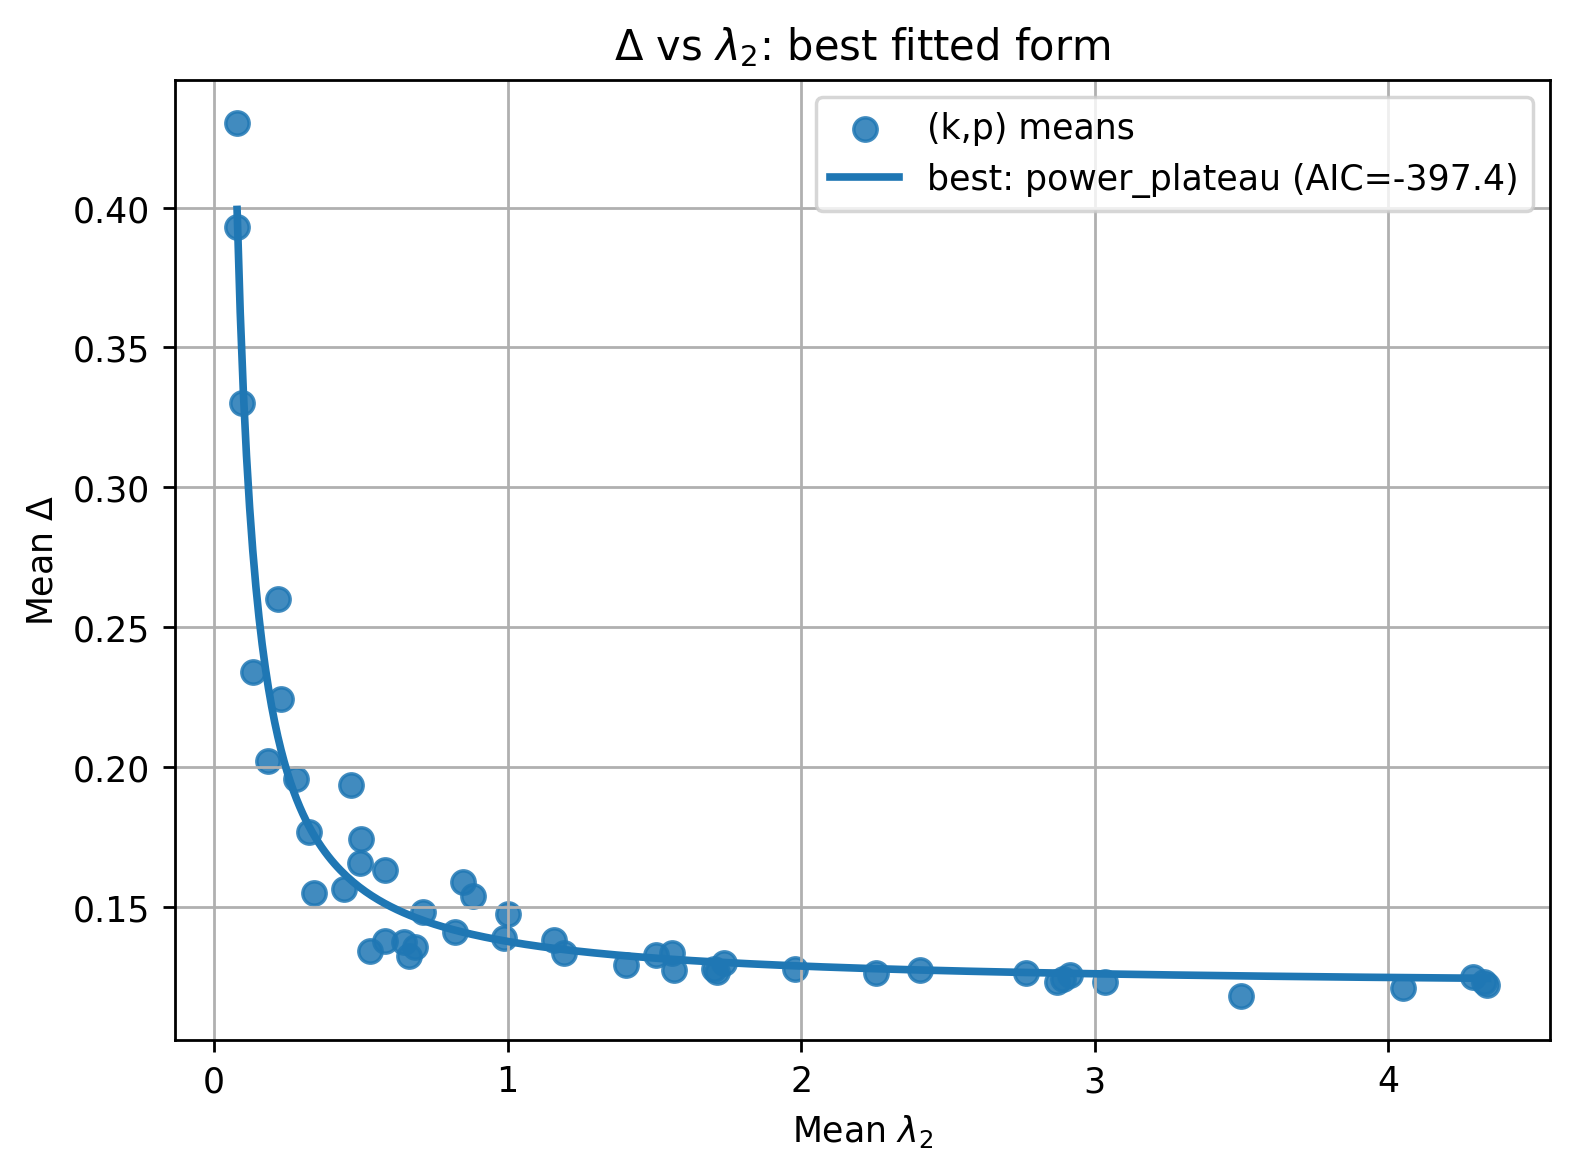

Best model: power_plateau
Parameters [a, b, c]: [0.01637953 1.11346097 0.12123884]
AIC: -397.3932203909724


In [13]:

try:
    from scipy.optimize import curve_fit
    HAVE_SCIPY = True
except Exception:
    HAVE_SCIPY = False


def exp_plateau(x, a, b, c):
    return c + a * np.exp(-b * x)

def power_plateau(x, a, b, c):
    # c + a * x^{-b}
    # NOTE: x must be > 0 (we will filter tiny x)
    return c + a * (x ** (-b))

def rational_plateau(x, a, b, c):
    # c + a / (x + b)
    return c + a / (x + b)

MODELS = {
    "exp_plateau": (exp_plateau, 3),
    "power_plateau": (power_plateau, 3),
    "rational_plateau": (rational_plateau, 3),
}


def fit_model(x, y, fn, k_params):
    """
    Returns: popt, rss, aic
    AIC = n*ln(RSS/n) + 2k  (Gaussian errors, unknown variance)
    """
    n = len(x)

    # initial guesses (simple + stable)
    c0 = float(np.median(y[x > np.quantile(x, 0.7)]) if np.any(x > np.quantile(x, 0.7)) else np.min(y))
    a0 = float(max(y.max() - c0, 1e-6))
    b0 = 1.0

    p0 = [a0, b0, c0]

    if HAVE_SCIPY:
        # Bounds to keep things sensible
        # a >= 0, b >= 0, c >= 0
        bounds = ([0.0, 0.0, 0.0], [np.inf, np.inf, np.inf])

        # Special handling for rational: keep x+b > 0
        if fn is rational_plateau:
            # allow b >= 0 is fine since x >= 0
            pass

        popt, _ = curve_fit(fn, x, y, p0=p0, bounds=bounds, maxfev=20000)
        yhat = fn(x, *popt)
    else:
        grid = np.linspace(0.3, 3.0, 30)
        best = None
        for g1 in grid:
            for g2 in grid:
                for g3 in grid:
                    popt_try = np.array([a0*g1, b0*g2, max(0.0, c0*g3)])
                    yhat_try = fn(x, *popt_try)
                    rss_try = np.sum((y - yhat_try)**2)
                    if (best is None) or (rss_try < best[0]):
                        best = (rss_try, popt_try, yhat_try)
        rss, popt, yhat = best

    rss = float(np.sum((y - yhat)**2))
    rss = max(rss, 1e-300)
    aic = float(n * np.log(rss / n) + 2 * k_params)
    return np.asarray(popt, float), rss, aic

def pick_best_fit(df_sum, xcol="lambda2_mean", ycol="delta_mean", xmin=1e-6):
    x = df_sum[xcol].to_numpy(dtype=float)
    y = df_sum[ycol].to_numpy(dtype=float)

    m = np.isfinite(x) & np.isfinite(y) & (x > xmin) & (y >= 0)
    x = x[m]; y = y[m]

    fits = {}
    for name, (fn, kpar) in MODELS.items():
        try:
            popt, rss, aic = fit_model(x, y, fn, kpar)
            fits[name] = dict(fn=fn, popt=popt, rss=rss, aic=aic)
        except Exception as e:
            fits[name] = dict(fn=None, popt=None, rss=np.inf, aic=np.inf, err=str(e))

    best_name = min(fits.keys(), key=lambda n: fits[n]["aic"])
    return best_name, fits, x, y


best_name, fits, x, y = pick_best_fit(df_sum)

best = fits[best_name]
fn = best["fn"]
popt = best["popt"]
aic = best["aic"]

xg = np.linspace(x.min(), x.max(), 400)
yg = fn(xg, *popt)

plt.figure(dpi=250)
plt.scatter(x, y, s=45, alpha=0.85, label="(k,p) means")
plt.plot(xg, yg, linewidth=2.2, label=f"best: {best_name} (AIC={aic:.1f})")
plt.xlabel("Mean $\\lambda_2$")
plt.ylabel("Mean $\\Delta$")
plt.title("$\\Delta$ vs $\\lambda_2$: best fitted form")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Best model:", best_name)
print("Parameters [a, b, c]:", popt)
print("AIC:", aic)


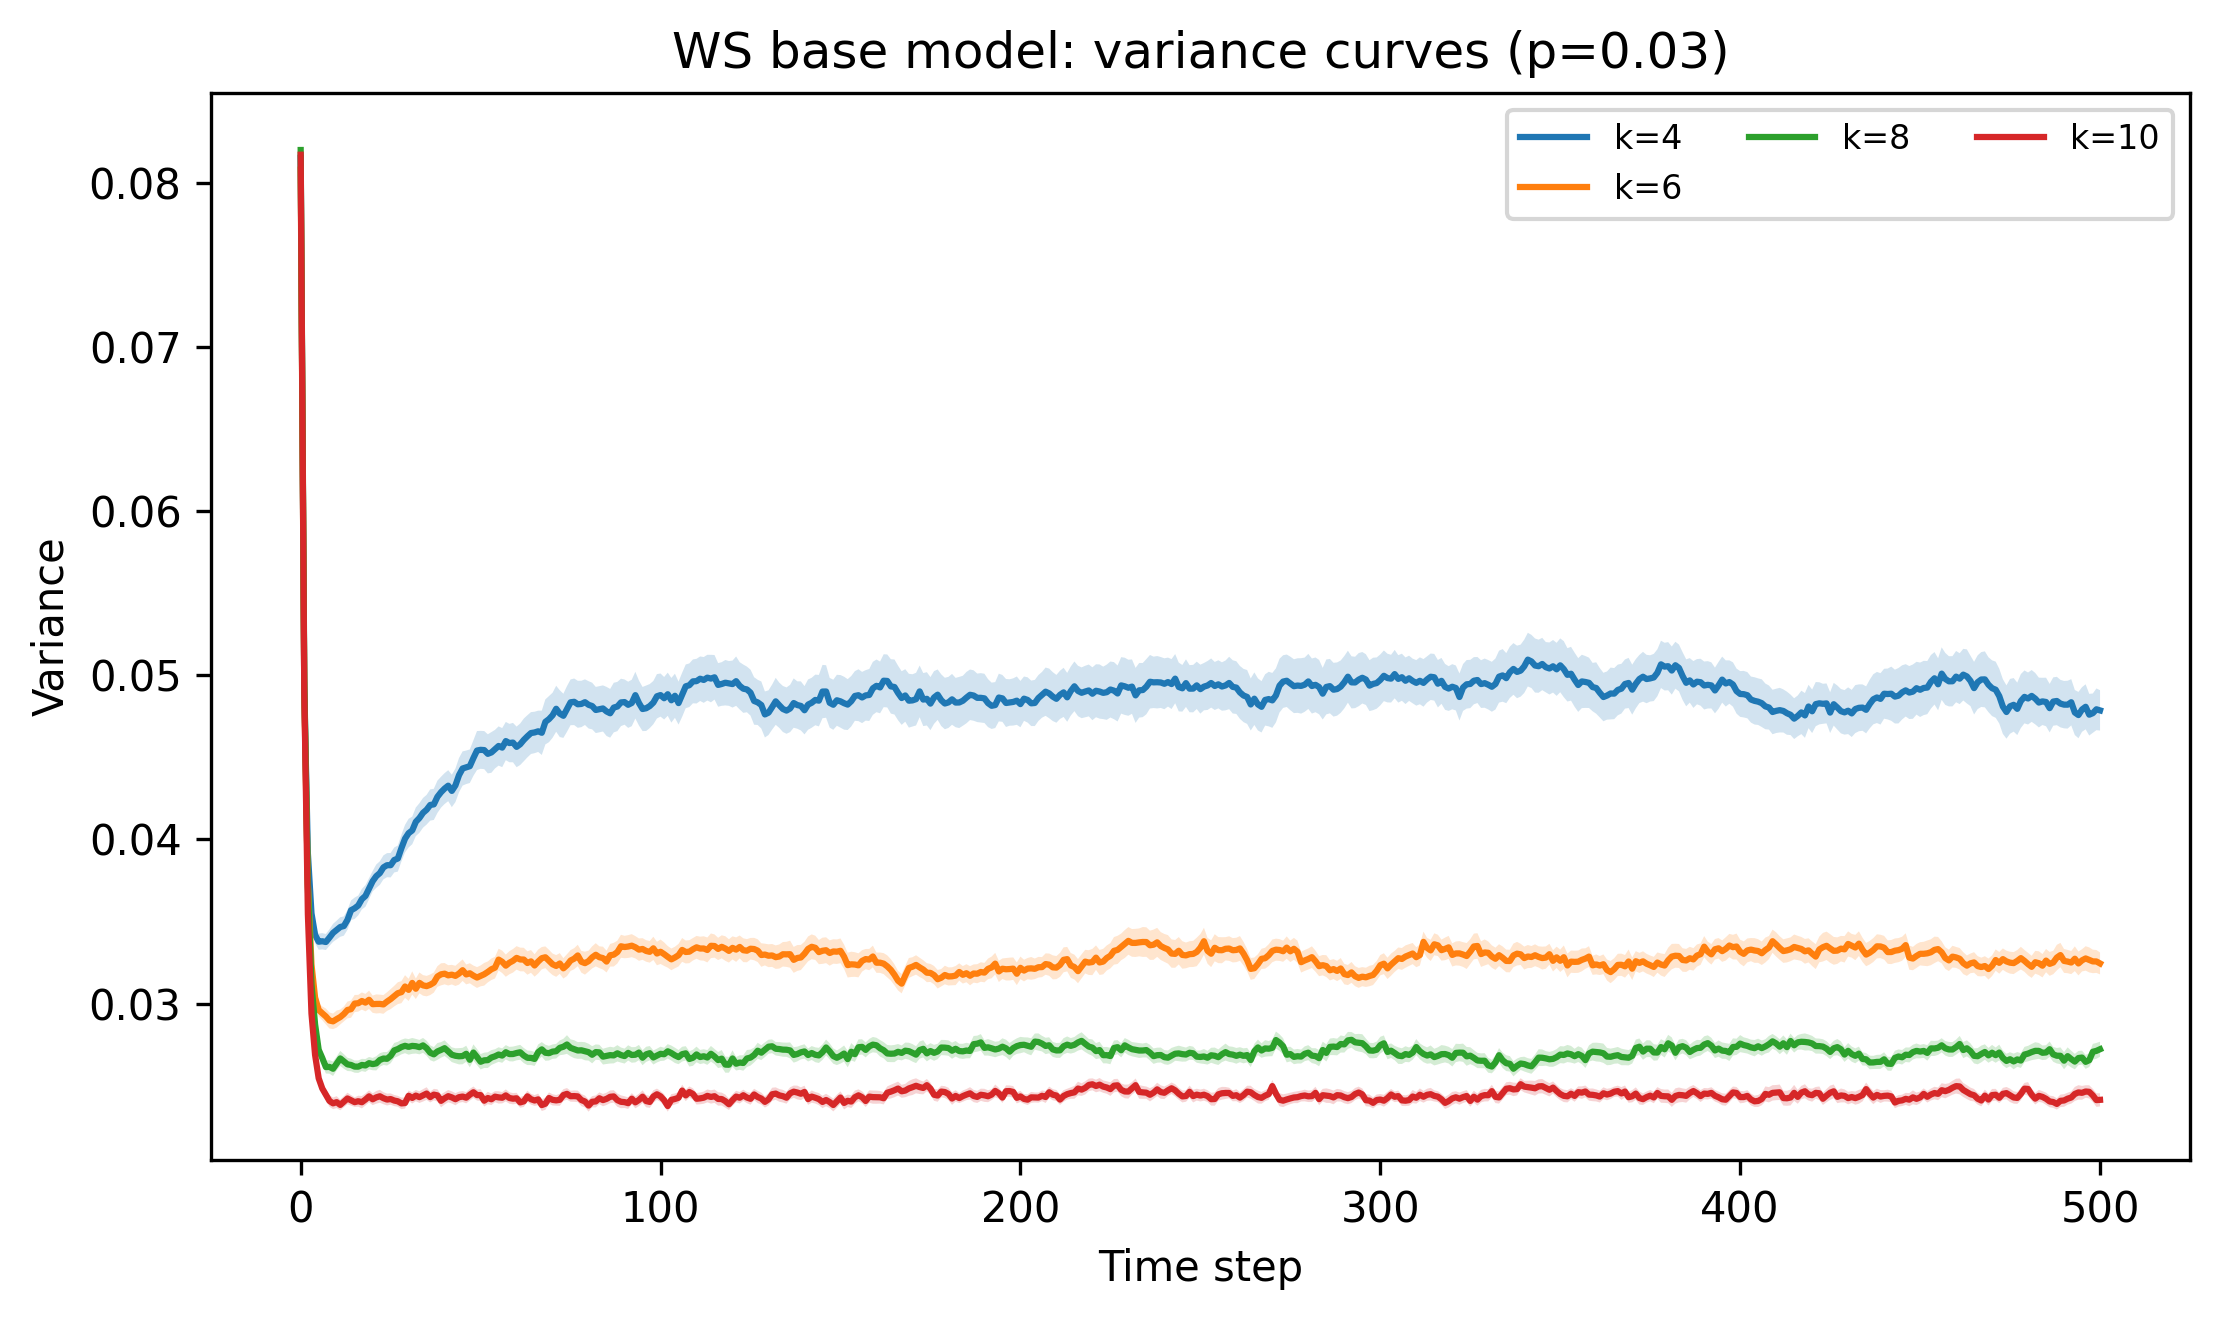

In [14]:

csv_path = r"./results_ws_nonlinearity_base/ws_base_timeseries_ALL.csv"

p_target = 0.030
p_tol = 1e-12          
use_col = "sem_total" 

df = pd.read_csv(csv_path)

needed = {"k","p","t","variance_mean", use_col}
missing = needed - set(df.columns)
if missing:
    raise ValueError(f"CSV is missing columns: {missing}. Found: {list(df.columns)}")

mask = np.isclose(df["p"].astype(float).values, p_target, atol=p_tol, rtol=0.0)
dfp = df.loc[mask].copy()

if dfp.empty:
    print("No rows found for p≈0.10. Available p values:")
    print(np.sort(dfp["p"].unique()) if "p" in df.columns else "p column not found")
    print("Try increasing p_tol, e.g. p_tol=1e-3")
    raise SystemExit

dfp["k"] = dfp["k"].astype(int)
dfp["t"] = dfp["t"].astype(int)
dfp = dfp.sort_values(["k","t"])

plt.figure(figsize=(7.5, 4.5), dpi=300)

for k in sorted(dfp["k"].unique()):
    d = dfp[dfp["k"] == k]
    t = d["t"].to_numpy()
    m = d["variance_mean"].to_numpy()
    s = d[use_col].to_numpy()

    plt.plot(t, m, label=f"k={k}")
    plt.fill_between(t, m - s, m + s, alpha=0.20)

plt.xlabel("Time step")
plt.ylabel("Variance")
plt.title(f"WS base model: variance curves (p={p_target:.2f})")
plt.legend(ncol=3, fontsize=8)   
plt.tight_layout()

plt.savefig("overlay_variance_all_k_p0.10.png")
plt.show()


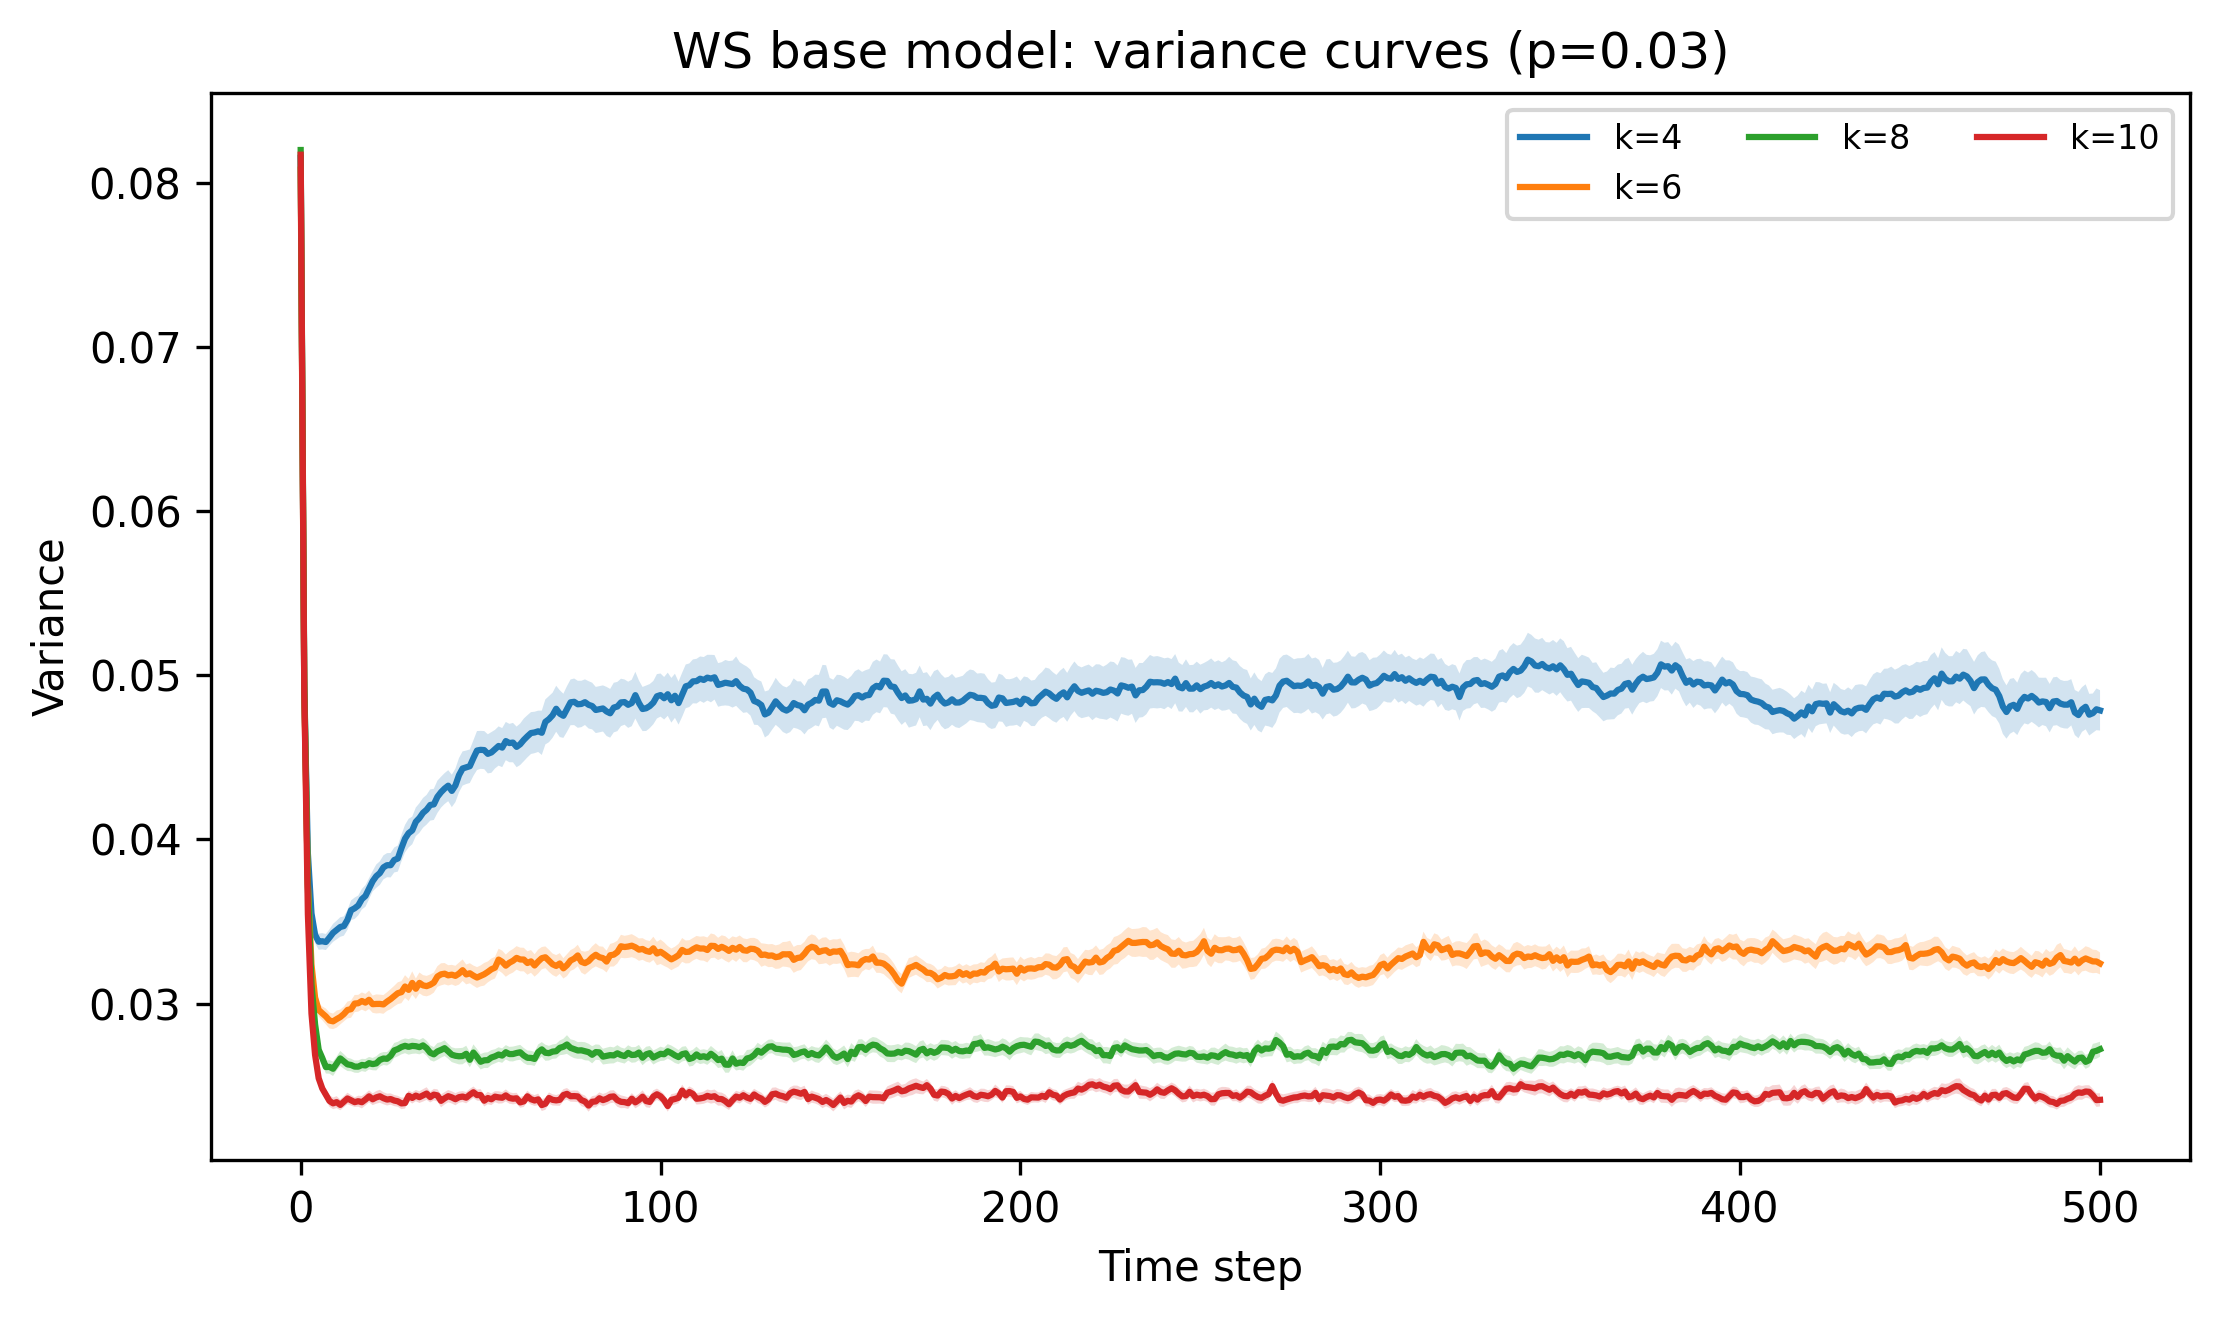

In [15]:

csv_path = r"./results_ws_nonlinearity_base/ws_base_timeseries_ALL.csv"

p_target = 0.030
p_tol = 1e-12          
use_col = "sem_total" 

df = pd.read_csv(csv_path)

needed = {"k","p","t","variance_mean", use_col}
missing = needed - set(df.columns)
if missing:
    raise ValueError(f"CSV is missing columns: {missing}. Found: {list(df.columns)}")

mask = np.isclose(df["p"].astype(float).values, p_target, atol=p_tol, rtol=0.0)
dfp = df.loc[mask].copy()

if dfp.empty:
    print("No rows found for p≈0.10. Available p values:")
    print(np.sort(dfp["p"].unique()) if "p" in df.columns else "p column not found")
    print("Try increasing p_tol, e.g. p_tol=1e-3")
    raise SystemExit

dfp["k"] = dfp["k"].astype(int)
dfp["t"] = dfp["t"].astype(int)
dfp = dfp.sort_values(["k","t"])

plt.figure(figsize=(7.5, 4.5), dpi=300)

for k in sorted(dfp["k"].unique()):
    d = dfp[dfp["k"] == k]
    t = d["t"].to_numpy()
    m = d["variance_mean"].to_numpy()
    s = d[use_col].to_numpy()

    plt.plot(t, m, label=f"k={k}")
    plt.fill_between(t, m - s, m + s, alpha=0.20)

plt.xlabel("Time step")
plt.ylabel("Variance")
plt.title(f"WS base model: variance curves (p={p_target:.2f})")
plt.legend(ncol=3, fontsize=8)   
plt.tight_layout()

plt.savefig("overlay_variance_all_k_p0.10.png")
plt.show()
